### 1. DETECTAR LOCALITZACIÓ MATRICULA

In [211]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import joblib
from skimage import transform
import Levenshtein

In [212]:
model_path = os.path.join(os.getcwd(), 'best.pt')
model_path1 = os.path.join(os.getcwd(), 'model_svc.pkl')

# carregar el model yolo entrenat 
model = YOLO(model_path)

svc_model = joblib.load(model_path1)

# path imatge(s) que vull predir
image_path = os.path.join(os.getcwd(), 'image-test')

In [213]:
def localitzacio_matricula(results, img):
# iterar sobre els resultats i extreure info bounding box
    for result in results:
        if hasattr(result, 'boxes'):  #tingui atribut boxes
            for box in result.boxes:
                x1, y1, x2, y2 = map(int, box.xyxy[0])  # extreure bonding box coordenades
                #print(f"Bounding Box: ({x1}, {y1}), ({x2}, {y2})")

                # load image original
                #image = cv2.imread(img)

                # dibuixar la bounding box
                #cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 5)
            
            # mostrar imatge original amb rectangle
            #plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
            #plt.axis('off')
            #plt.show()
        #else:
            #print("No bounding boxes found in this result.")
        
    # extreure la matricula de la imateg original = ROI
    roi = image[y1:y2, x1:x2] 
    #plt.imshow(roi)
    return roi, x1, x2, y1, y2

### 2. SEGMENTAR MATRICULA

In [214]:
def segmentar_matricula(x1,x2,y1,y2,image):
    #ficar un desplaçament per així no captura la E europea. 
    desplacament = 21

    #definir els 4 corners basats en bounding box
    top_left = (x1+desplacament, y1)
    top_right = (x2, y1)
    bottom_right = (x2, y2)
    bottom_left = (x1+desplacament, y2)

    # ordenar en source order
    pts_src = np.array([top_left, top_right, bottom_right, bottom_left], dtype="float32")
    #print(pts_src)

    # outout size dimensions
    width, height = 500, 70  
    pts_dst = np.array([[0, 0], [width, 0], [width, height], [0, height]], dtype="float32")
    #print(pts_dst)

    # matriu de transformacio perspectiva mitjançant punts source i output
    M = cv2.getPerspectiveTransform(pts_src, pts_dst)

    #aplicar transformacio 
    warped_image = cv2.warpPerspective(image, M, (width, height))
    plt.imshow(warped_image)
    plt.axis('off')
    plt.show()



    #passar a HSV === això ajuda a treure la E europea
    image = cv2.cvtColor(warped_image, cv2.COLOR_BGR2HSV)
    image = image[:, :, 2] #ens quedem amb la capa V
    cv2.GaussianBlur(image, (5, 5), 0)
    #threshold de otsu
    thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU) [1]
    #invertir imatge
    negative_image = 255 - thresh

    contours, _ = cv2.findContours(negative_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Filtrar contours
    character_contours = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / float(h)
        
        if 0.1 < aspect_ratio < 3.0 and 5 < w < 200 and 10 < h < 50:
            character_contours.append((x, y, w, h))

    #ordenar 
    character_contours = sorted(character_contours, key=lambda b: b[0])

    chars = list()
    #mostrar els caracters
    if character_contours:
        for (x, y, w, h) in character_contours:
            char_image = negative_image[y:y + h, x:x + w]
            chars.append(char_image)
            
    else:
        print("no contours found")

    return chars
    

### 3. COMPARATIVA DE TEXT

In [215]:
def comparativa_text(label, pred):
    # Comparación simple
    if label == pred:
        print("La matrícula predita és correcta.")
    else:
        print("La matrícula predicha és incorrecta.")

    # Calcular la distancia de Levenshtein
    distancia = Levenshtein.distance(label, pred)
    print(f"Distància de Levenshtein: {distancia}")

    # Calcular similitud de Levenshtein
    similaridad = 1 - (distancia / max(len(label), len(pred)))
    print(f"Similitud de Levenshtein: {similaridad:.4f}")

    # Mostrar resultados
    print(f"Etiqueta real: {label}")
    print(f"Predicció: {pred}")


### 5. PREDICCIONS

In [216]:
import pandas as pd

# Cargar el archivo Excel
ruta_archivo = os.path.join(os.getcwd(),'bd-image-test.xlsx')  # Cambia esto a la ruta de tu archivo
df = pd.read_excel(ruta_archivo)

# Crear el diccionario
# Suponiendo que la primera columna es la que queremos usar como clave
# y la segunda columna como valor
diccionario = dict(zip(df.iloc[:, 0], df.iloc[:, 1]))

# Mostrar el diccionario
print(diccionario)

{'img2.png': '2522LNH', 'img3.png': '2021AXP', 'img4.png': '8878LWB', 'img5.png': '3587KSG', 'img6.png': '4138KFK', 'img1.png': '5025JJM'}



image 1/1 c:\Users\macia\OneDrive\Escriptori\4t GED\PSIV\image-test\img1.png: 416x640 1 License-Plate, 114.0ms
Speed: 2.0ms preprocess, 114.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


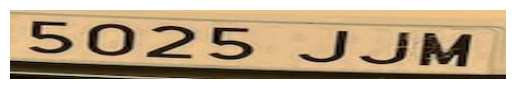

La matrícula predita és correcta.
Distància de Levenshtein: 0
Similitud de Levenshtein: 1.0000
Etiqueta real: 5025JJM
Predicció: 5025JJM

image 1/1 c:\Users\macia\OneDrive\Escriptori\4t GED\PSIV\image-test\img2.png: 448x640 1 License-Plate, 116.0ms
Speed: 3.0ms preprocess, 116.0ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


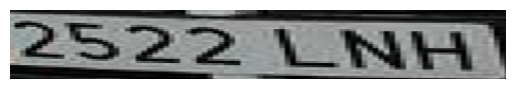

La matrícula predita és correcta.
Distància de Levenshtein: 0
Similitud de Levenshtein: 1.0000
Etiqueta real: 2522LNH
Predicció: 2522LNH

image 1/1 c:\Users\macia\OneDrive\Escriptori\4t GED\PSIV\image-test\img3.png: 544x640 1 License-Plate, 140.0ms
Speed: 8.0ms preprocess, 140.0ms inference, 2.0ms postprocess per image at shape (1, 3, 544, 640)


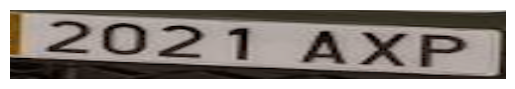

Error de segmentació
La matrícula predicha és incorrecta.
Distància de Levenshtein: 2
Similitud de Levenshtein: 0.7500
Etiqueta real: 2021AXP
Predicció: 720214XP

image 1/1 c:\Users\macia\OneDrive\Escriptori\4t GED\PSIV\image-test\img4.png: 384x640 1 License-Plate, 110.0ms
Speed: 6.0ms preprocess, 110.0ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


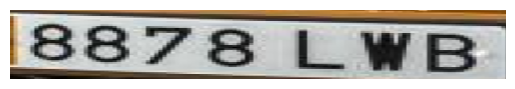

La matrícula predita és correcta.
Distància de Levenshtein: 0
Similitud de Levenshtein: 1.0000
Etiqueta real: 8878LWB
Predicció: 8878LWB

image 1/1 c:\Users\macia\OneDrive\Escriptori\4t GED\PSIV\image-test\img5.png: 448x640 1 License-Plate, 147.5ms
Speed: 2.0ms preprocess, 147.5ms inference, 1.0ms postprocess per image at shape (1, 3, 448, 640)


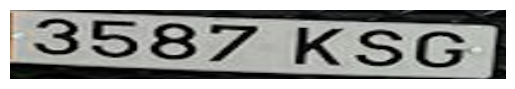

La matrícula predita és correcta.
Distància de Levenshtein: 0
Similitud de Levenshtein: 1.0000
Etiqueta real: 3587KSG
Predicció: 3587KSG

image 1/1 c:\Users\macia\OneDrive\Escriptori\4t GED\PSIV\image-test\img6.png: 416x640 1 License-Plate, 99.0ms
Speed: 1.0ms preprocess, 99.0ms inference, 1.0ms postprocess per image at shape (1, 3, 416, 640)


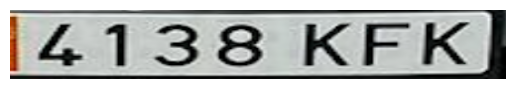

La matrícula predita és correcta.
Distància de Levenshtein: 0
Similitud de Levenshtein: 1.0000
Etiqueta real: 4138KFK
Predicció: 4138KFK


In [217]:
for image in os.listdir(image_path):
    nom = image
    path = os.path.join(image_path,str(image))
    image = cv2.imread(path)
    result = model.predict(path)
    roi, x1, x2, y1, y2 = localitzacio_matricula(result, image)
    chars = segmentar_matricula(x1, x2, y1, y2, image)
    
    matricula = []
    for char in chars:
        img_resized = transform.resize(char, (32, 32), anti_aliasing=True)
        img_flatten = img_resized.flatten()
        img = img_flatten.reshape(1, -1)
        
        #Afegim la imatge i la seva etiqueta a les llistes corresponents
        pred = svc_model.predict(img)
        matricula.append(str(pred[0]))
    
    if len(matricula) !=7:
        print('Error de segmentació')
    
    label = diccionario[nom]
    matricula = ''.join(matricula)
    comparativa_text(label, matricula)
